### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.layers import Conv2D, Reshape
from keras import Model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.backend import epsilon

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load the training data from train.csv file

In [87]:
train = pd.read_csv('/content/gdrive/My Drive/AIML/Labs/R9/R9-Internal/train_labels.csv')
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [88]:
train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE=128

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

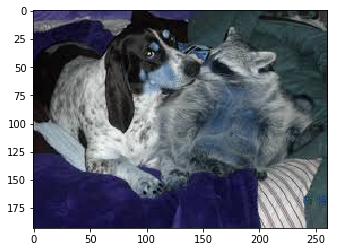

In [90]:
eg = cv2.imread('/content/gdrive/My Drive/AIML/Labs/R9/R9-Internal/images/images/raccoon-200.jpg')
plt.imshow(eg)

In [91]:
train[train['filename']=='raccoon-200.jpg']

,filename,width,height,class,xmin,ymin,xmax,ymax
7,raccoon-200.jpg,261,193,raccoon,107,10,249,166


In [92]:
train.shape[0]

173

In [0]:
coords = np.zeros((train.shape[0],4))

In [0]:
path=[]
x0=[]
y0=[]
x1=[]
y1=[]
xcords=[]
ycords=[]
wcords=[]
hcords=[]

for index,row in train.iterrows():
  #print(index)
  path.append('/content/gdrive/My Drive/AIML/Labs/R9/R9-Internal/images/images/'+row['filename'])
  width = row['width']
  height = row['height']
  scalew = width/IMAGE_SIZE
  scaleh = height/IMAGE_SIZE
  x0.append(row['xmin']/scalew)
  x1.append(row['xmax']/scalew)
  y0.append(row['ymin']/scaleh)
  y1.append(row['ymax']/scaleh)
  xcords.append(row['xmin']/scalew)
  ycords.append(row['ymin']/scaleh)
  wcords.append(row['xmax']/scalew-row['xmin']/scalew)
  hcords.append(row['ymax']/scalew-row['ymin']/scaleh)

In [0]:
train['x0'] = x0
train['y0'] = y0
train['x1'] = x1
train['y1'] = y1
train['path'] = path

In [96]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,x0,y0,x1,y1,path
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,46.949807,39.587629,82.532819,77.855670,/content/gdrive/My Drive/AIML/Labs/R9/R9-Inter...
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,0.581818,0.296296,89.406061,127.703704,/content/gdrive/My Drive/AIML/Labs/R9/R9-Inter...
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290,15.786667,34.240000,59.733333,92.800000,/content/gdrive/My Drive/AIML/Labs/R9/R9-Inter...
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298,48.426667,29.760000,85.973333,95.360000,/content/gdrive/My Drive/AIML/Labs/R9/R9-Inter...
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,27.194139,22.832432,92.366300,87.870270,/content/gdrive/My Drive/AIML/Labs/R9/R9-Inter...


In [0]:
train1 = train.copy(deep=True)
train = train1[0:150]
val = train1[151:160]
test = train1[161:172]

In [98]:
print(train.shape)

(150, 13)


In [99]:
print(val.shape)

(9, 13)


In [100]:
print(test.shape)

(11, 13)


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(train['path']), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(train['path']):
    try:
        img = Image.open(f) # Read image
    except:
        print(f)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [0]:
batch_images_val = np.zeros((len(val['path']), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(val['path']):
    try:
        img = Image.open(f) # Read image
    except:
        print(f)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images_val[i] = preprocess_input(np.array(img, dtype=np.float32))

In [0]:
batch_images_test = np.zeros((len(test['path']), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(test['path']):
    try:
        img = Image.open(f) # Read image
    except:
        print(f)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images_test[i] = preprocess_input(np.array(img, dtype=np.float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


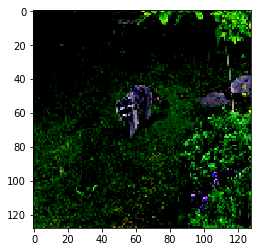

In [104]:
plt.imshow(batch_images[0])

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(optimizer='adam',loss='mse',metrics=[IoU])

In [109]:
coords=pd.DataFrame({'xcords':xcords,'ycords':ycords,'wcords':wcords,'hcords':hcords})
coords.head()

,xcords,ycords,wcords,hcords
0,46.949807,39.587629,35.583012,18.728973
1,0.581818,0.296296,88.824242,83.291582
2,15.786667,34.240000,43.946667,27.626667
3,48.426667,29.760000,37.546667,33.813333
4,27.194139,22.832432,65.172161,36.713355


In [0]:
coords_train = coords[0:150]
coords_val = coords[151:160]
coords_test = coords[161:172]

In [111]:
print(coords_train.shape)
print(coords_val.shape)
print(coords_test.shape)

(150, 4)
(9, 4)
(11, 4)


In [0]:
coords_array = np.array(coords)
coords_array_train = np.array(coords_train)
coords_array_val = np.array(coords_val)
coords_array_test = np.array(coords_test)

In [113]:
model.fit(batch_images,coords_array_train,epochs=60,batch_size=32,verbose=1,validation_data=(batch_images_val,coords_array_val))

Train on 150 samples, validate on 9 samples
Epoch 1/60
150/150 [==============================] - 2s 14ms/step - loss: 2455.9417 - IoU: 0.0723 - val_loss: 1174.7505 - val_IoU: 0.2133
Epoch 2/60
150/150 [==============================] - 0s 841us/step - loss: 732.7886 - IoU: 0.3803 - val_loss: 1391.0156 - val_IoU: 0.3577
Epoch 3/60
150/150 [==============================] - 0s 837us/step - loss: 687.2801 - IoU: 0.4716 - val_loss: 1886.7648 - val_IoU: 0.3415
Epoch 4/60
150/150 [==============================] - 0s 702us/step - loss: 690.7670 - IoU: 0.4685 - val_loss: 1496.5973 - val_IoU: 0.3541
Epoch 5/60
150/150 [==============================] - 0s 656us/step - loss: 440.7592 - IoU: 0.5073 - val_loss: 1080.7677 - val_IoU: 0.3887
Epoch 6/60
150/150 [==============================] - 0s 571us/step - loss: 343.3504 - IoU: 0.5403 - val_loss: 955.2045 - val_IoU: 0.3444
Epoch 7/60
150/150 [==============================] - 0s 604us/step - loss: 327.8579 - IoU: 0.5164 - val_loss: 909.5683 - v

### Pick a test image from the given data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


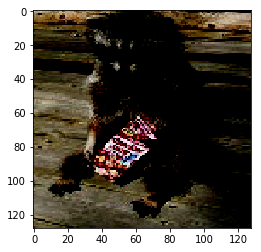

In [114]:
plt.imshow(batch_images_test[0])

In [115]:
coords_array_test[7]

array([28.4       ,  4.26666667, 93.2       , 88.93333333])

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


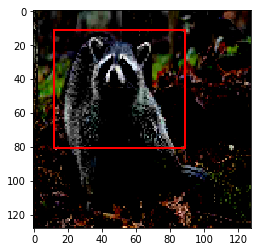

In [117]:
# Create figure and axes
fig,ax = plt.subplots(1)

fig_num = 110

# Display the image
scaled = batch_images[fig_num]
ax.imshow(scaled)

# Create a Rectangle patch
rect = patches.Rectangle((coords_array[fig_num,0], coords_array[fig_num,1]), coords_array[fig_num,2],coords_array[fig_num,3], linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


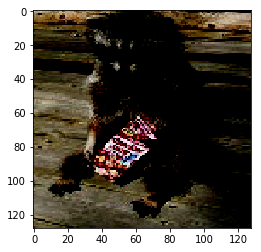

In [118]:
plt.imshow(batch_images_test[0])

### Predict the coordinates of the bounding box for the given test image

In [119]:
test_predict = model.predict(batch_images_test,verbose=1)
test_predict

11/11 [==============================] - 1s 75ms/step


array([[ 20.360334 ,   4.903305 ,  87.131546 ,  99.328476 ],
       [ 17.883741 ,  12.362153 ,  88.863266 ,  74.80647  ],
       [  1.947598 ,  -3.2460017,  76.40408  ,  68.54729  ],
       [ 27.295433 ,  16.555647 ,  93.602844 , 105.27069  ],
       [ 25.666216 ,  10.508014 ,  88.98701  ,  85.04987  ],
       [ 14.948337 ,   5.4304037, 109.45236  , 136.35495  ],
       [ 31.81835  ,  15.526594 ,  98.55077  ,  71.330154 ],
       [ 18.674849 ,   6.4689293,  86.87717  , 113.279144 ],
       [ 36.306164 ,  14.2636385,  85.29886  ,  86.07767  ],
       [ 24.651129 ,  19.055609 ,  87.06293  ,  69.24991  ],
       [ 37.316483 ,  20.758593 ,  62.446526 ,  66.76737  ]],
      dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


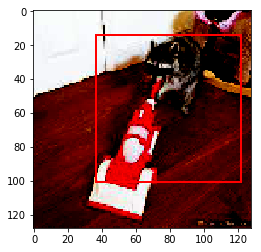

In [120]:
# Create figure and axes
fig,ax = plt.subplots(1)

fig_num = 8

# Display the image
scaled = batch_images_test[fig_num]
ax.imshow(scaled)

# Create a Rectangle patch
rect = patches.Rectangle((test_predict[fig_num,0], test_predict[fig_num,1]), test_predict[fig_num,2],test_predict[fig_num,3], linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

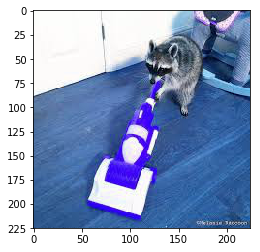

In [121]:
plt.imshow(cv2.imread(np.array(test['path'])[8]))

1.75
1.7578125


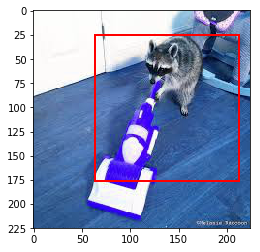

In [122]:
# Create figure and axes
fig,ax = plt.subplots(1)

fig_num = 8

# Display the image
pathArray = np.array(test['path'])
widthArray = np.array(test['width'])
heightArray = np.array(test['height'])

imgPath = pathArray[fig_num]
widthUnscale = widthArray[fig_num]/IMAGE_SIZE
heightUnscale = heightArray[fig_num]/IMAGE_SIZE

print(widthUnscale)
print(heightUnscale)

unscaled = cv2.imread(imgPath)
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((test_predict[fig_num,0]*widthUnscale, 
test_predict[fig_num,1]*heightUnscale), test_predict[fig_num,2]*widthUnscale,
test_predict[fig_num,3]*heightUnscale, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Problem 2 : Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [0]:
import pandas as pd
import numpy as np

#### Mount google drive

In [34]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Load the  data file

In [35]:
temp = pd.read_csv('/content/gdrive/My Drive/AIML/Labs/R9/R9-Internal/daily-minimum-temperatures-in-me.csv')
temp.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Plot the data

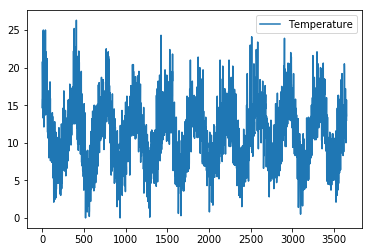

In [36]:
temp.plot()

### Check for null values and treat them

In [37]:
temp.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values (if any)

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8996145860>]],
      dtype=object)

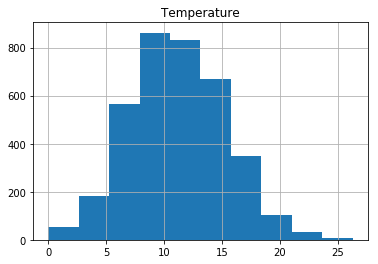

In [38]:
temp.hist()

### Check the maximum and minimum values

In [39]:
temp.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [40]:
# Scaled Data
print('Min', np.min(temp))
print('Max', np.max(temp))

Min Date           1981-01-01
Temperature             0
dtype: object
Max Date           1990-12-31
Temperature          26.3
dtype: object


### Normalize the data

In [41]:
temp['Temperature_flt'] = temp[['Temperature']].astype('float32')
temp.head()

,Date,Temperature,Temperature_flt
0,1981-01-01,20.7,20.700001
1,1981-01-02,17.9,17.900000
2,1981-01-03,18.8,18.799999
3,1981-01-04,14.6,14.600000
4,1981-01-05,15.8,15.800000


In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
temp['Temperature_flt_scaled'] = scaler.fit_transform(np.array(temp['Temperature_flt']).reshape(-1,1))
temp.head()

,Date,Temperature,Temperature_flt,Temperature_flt_scaled
0,1981-01-01,20.7,20.700001,0.787072
1,1981-01-02,17.9,17.900000,0.680608
2,1981-01-03,18.8,18.799999,0.714829
3,1981-01-04,14.6,14.600000,0.555133
4,1981-01-05,15.8,15.800000,0.600761


### Check the maximum and minimum values of scaled data

In [43]:
print(np.min(temp['Temperature_flt_scaled']))
print(np.max(temp['Temperature_flt_scaled']))

0.0
1.0


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [44]:
temp1 = temp[['Temperature_flt_scaled']]
temp1.head()

,Temperature_flt_scaled
0,0.787072
1,0.680608
2,0.714829
3,0.555133
4,0.600761


In [45]:
temp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 1 columns):
Temperature_flt_scaled    3650 non-null float32
dtypes: float32(1)
memory usage: 14.3 KB


In [46]:
#Create the model
train_size = int(len(temp1) * 0.70)
print(train_size)
test_size = len(temp1 - train_size)
print(test_size)
train = temp1.loc[0:train_size, :]
test = temp1.loc[train_size: len(temp1), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

2555
3650
train: 2556
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [48]:
look_back = 1
X_train, y_train = create_dataset(np.array(train), look_back)
X_test, y_test = create_dataset(np.array(test), look_back)

2556 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806084
1
X 1 to 2
[0.6806084]
Y 2
0.7148289
2
X 2 to 3
[0.7148289]
Y 3
0.5551331
3
X 3 to 4
[0.5551331]
Y 4
0.6007605
4
X 4 to 5
[0.6007605]
Y 5
0.6007605
5
X 5 to 6
[0.6007605]
Y 6
0.6007605
6
X 6 to 7
[0.6007605]
Y 7
0.661597
7
X 7 to 8
[0.661597]
Y 8
0.82889736
8
X 8 to 9
[0.82889736]
Y 9
0.7604563
9
X 9 to 10
[0.7604563]
Y 10
0.61596966
10
X 10 to 11
[0.61596966]
Y 11
0.50570345
11
X 11 to 12
[0.50570345]
Y 12
0.63498104
12
X 12 to 13
[0.63498104]
Y 13
0.8174906
13
X 13 to 14
[0.8174906]
Y 14
0.9505704
14
X 14 to 15
[0.9505704]
Y 15
0.7870723
15
X 15 to 16
[0.7870723]
Y 16
0.78327
16
X 16 to 17
[0.78327]
Y 17
0.9429658
17
X 17 to 18
[0.9429658]
Y 18
0.67300385
18
X 18 to 19
[0.67300385]
Y 19
0.5893537
19
X 19 to 20
[0.5893537]
Y 20
0.6920153
20
X 20 to 21
[0.6920153]
Y 21
0.4600761
21
X 21 to 22
[0.4600761]
Y 22
0.54752856
22
X 22 to 23
[0.54752856]
Y 23
0.60836506
23
X 23 to 24
[0.60836506]
Y 24
0.62737644
24
X 24 to 25
[0.62737644]
Y 25
0.7110

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [49]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1093, 1, 1)


In [50]:
print(y_test.shape)
print(y_train.shape)

(1093,)
(2554,)


### Define sequntial model, add LSTM layer and compile the model

In [51]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=2, shuffle=True, validation_data=(X_test,y_test))

Train on 2554 samples, validate on 1093 samples
Epoch 1/10
 - 13s - loss: 0.0254 - val_loss: 0.0092
Epoch 2/10
 - 12s - loss: 0.0173 - val_loss: 0.0100
Epoch 3/10
 - 13s - loss: 0.0131 - val_loss: 0.0097
Epoch 4/10
 - 12s - loss: 0.0120 - val_loss: 0.0096
Epoch 5/10
 - 12s - loss: 0.0114 - val_loss: 0.0098
Epoch 6/10
 - 12s - loss: 0.0115 - val_loss: 0.0093
Epoch 7/10
 - 12s - loss: 0.0113 - val_loss: 0.0090
Epoch 8/10
 - 12s - loss: 0.0110 - val_loss: 0.0093
Epoch 9/10
 - 13s - loss: 0.0111 - val_loss: 0.0089
Epoch 10/10
 - 12s - loss: 0.0108 - val_loss: 0.0090


### Train the model for 100 epochs with batch size = 1

In [52]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True, validation_data=(X_test,y_test))

Train on 2554 samples, validate on 1093 samples
Epoch 1/100
 - 13s - loss: 0.0198 - val_loss: 0.0111
Epoch 2/100
 - 14s - loss: 0.0146 - val_loss: 0.0096
Epoch 3/100
 - 13s - loss: 0.0127 - val_loss: 0.0094
Epoch 4/100
 - 12s - loss: 0.0114 - val_loss: 0.0092
Epoch 5/100
 - 13s - loss: 0.0108 - val_loss: 0.0086
Epoch 6/100
 - 13s - loss: 0.0106 - val_loss: 0.0086
Epoch 7/100
 - 12s - loss: 0.0106 - val_loss: 0.0087
Epoch 8/100
 - 12s - loss: 0.0105 - val_loss: 0.0087
Epoch 9/100
 - 12s - loss: 0.0105 - val_loss: 0.0086
Epoch 10/100
 - 12s - loss: 0.0106 - val_loss: 0.0087
Epoch 11/100
 - 12s - loss: 0.0104 - val_loss: 0.0088
Epoch 12/100
 - 13s - loss: 0.0105 - val_loss: 0.0086
Epoch 13/100
 - 12s - loss: 0.0105 - val_loss: 0.0086
Epoch 14/100
 - 12s - loss: 0.0104 - val_loss: 0.0088
Epoch 15/100
 - 12s - loss: 0.0103 - val_loss: 0.0088
Epoch 16/100
 - 12s - loss: 0.0103 - val_loss: 0.0088
Epoch 17/100
 - 12s - loss: 0.0104 - val_loss: 0.0086
Epoch 18/100
 - 13s - loss: 0.0103 - val_lo

### Make Predictions and Evaluate your model

In [53]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.61 RMSE
Test Score: 2.47 RMSE
